In [1]:
#####################
# Train & Eval
#####################

# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Trains TFT based on a defined set of parameters.
Uses default parameters supplied from the configs file to train a TFT model from
scratch.

Usage:
python3 script_train_fixed_params {expt_name} {output_folder}

Command line args:
  expt_name: Name of dataset/experiment to train.
  output_folder: Root folder in which experiment is saved
"""

import argparse
import datetime as dte
import os,sys
sys.path.append('/tf/crypto_prediction_ml_dl/script')
sys.path.append('/tf/crypto_prediction_ml_dl/notebook/TFT_models')

import data_formatters.base
import expt_settings.configs
import libs.hyperparam_opt
import libs.tft_custom_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_custom_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

2023-11-19 12:27:08.795011: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 12:27:08.919816: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-19 12:27:10.591828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:27:10.603922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:27:10.604039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
def main_train(expt_name,
         use_gpu,
         model_folder,
         data_csv_path,
         data_formatter,
         use_testing_mode=False):
    """Trains tft based on defined model params.

    Args:
      expt_name: Name of experiment
      use_gpu: Whether to run tensorflow with GPU operations
      model_folder: Folder path where models are serialized
      data_csv_path: Path to csv file containing data
      data_formatter: Dataset-specific data fromatter (see
        expt_settings.dataformatter.GenericDataFormatter)
      use_testing_mode: Uses a smaller models and data sizes for testing purposes
        only -- switch to False to use original default settings
    """

    num_repeats = 1

    if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
        raise ValueError(
            "Data formatters should inherit from" +
            "AbstractDataFormatter! Type={}".format(type(data_formatter)))

    # Tensorflow setup
    default_keras_session = tf.keras.backend.get_session()

    if use_gpu:
        tf_config = utils.get_default_tensorflow_config(tf_device="gpu", gpu_id=0)

    else:
        tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

    print("*** Training from defined parameters for {} ***".format(expt_name))

    print("Loading & splitting data...")
    raw_data = pd.read_csv(data_csv_path, index_col=0)
    train, valid, test = data_formatter.split_data(raw_data)
    train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()

    # Sets up default params
    fixed_params = data_formatter.get_experiment_params()
    params = data_formatter.get_default_model_params()
    params["model_folder"] = model_folder

    # Parameter overrides for testing only! Small sizes used to speed up script.
    if use_testing_mode:
        fixed_params["num_epochs"] = 1
        params["hidden_layer_size"] = 5
        train_samples, valid_samples = 100, 10

    # Sets up hyperparam manager
    print("*** Loading hyperparm manager ***")
    opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                       fixed_params, model_folder)


    # Training -- one iteration only
    print("*** Running calibration ***")
    print("Params Selected:")
    for k in params:
        print("{}: {}".format(k, params[k]))

    best_loss = np.Inf
    for _ in range(num_repeats):

        tf.reset_default_graph()
        with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:

            tf.keras.backend.set_session(sess)

            params = opt_manager.get_next_parameters()
            model = ModelClass(params, use_cudnn=use_gpu)

            if not model.training_data_cached():
                model.cache_batched_data(train, "train", num_samples=train_samples)
                model.cache_batched_data(valid, "valid", num_samples=valid_samples)

            sess.run(tf.global_variables_initializer())
            model.fit()

            val_loss = model.evaluate()

            if val_loss < best_loss:
                opt_manager.update_score(params, val_loss, model)
                best_loss = val_loss

            tf.keras.backend.set_session(default_keras_session)

    print("*** Running tests ***")
    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session(config=tf_config) as sess:
        tf.keras.backend.set_session(sess)
        
        best_params = opt_manager.get_best_params()
        
        model = ModelClass(best_params, use_cudnn=use_gpu)

        model.load(opt_manager.hyperparam_folder)

        print("Computing best validation loss")
        val_loss = model.evaluate(valid)

        print("Computing test loss")
        output_map = model.predict_with_custom_loss(test, return_targets=True)

        targets = output_map["targets"]
        results = output_map["results"]

        tf.keras.backend.set_session(default_keras_session)

    print("Training completed @ {}".format(dte.datetime.now()))
    print("Best validation loss = {}".format(val_loss))
    print("Params:")

    for k in best_params:
        print(k, " = ", best_params[k])
    
    return output_map

In [8]:

dataset_name = 'crypto_day'
output_folder = '.'
use_tensorflow_with_gpu = 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(dataset_name, output_folder)
formatter = config.make_data_formatter()


# Customise inputs to main() for new datasets.
output_map = main_train(
    expt_name=dataset_name,
    use_gpu=use_tensorflow_with_gpu,
    model_folder=os.path.join(config.model_folder, "fixed"),
    data_csv_path=config.data_csv_path,
    data_formatter=formatter,
    use_testing_mode=False)  # Change to false to use original default params



Using output folder .
Selecting GPU ID=0
*** Training from defined parameters for crypto_day ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.3
hidden_layer_size: 160
learning_rate: 0.01
minibatch_size: 32
max_gradient_norm: 0.01
num_heads: 1
stack_size: 1
model_folder: ./saved_models/crypto_day/fixed
Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 160
# learning_rate = 0.01
# max_gradient_norm = 0.01
# minibatch_size = 32
# model_folder = ./saved_models/crypto_day/fixed
# num_heads = 1
# stack_size = 1
# total_time_steps = 31
# num_encoder_steps = 30
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id

2023-11-19 12:29:07.660921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:29:07.661263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:29:07.661532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-19 12:29:07.900224: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization/beta/Assign' id:440 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization/beta, TemporalFusionTransformer/layer_normalization/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:07.917816: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<t

2023-11-19 12:29:08.370085: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_11/stack_2' id:292 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_11/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:08.399230: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_1/dim' id:1333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_1/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no e

2023-11-19 12:29:09.095308: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_27/bias/Assign' id:2333 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_27/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_27/bias, TemporalFusionTransformer/time_distributed_27/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:09.139550: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_18/stack_1' id:2395 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_18/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor

2023-11-19 12:29:10.048931: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_1/reduction_indices' id:2794 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_1/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:10.108857: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/Sum_2/reduction_indices' id:3246 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/Sum_2/reduction_indices}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: -1>]()}}' was changed by setting attribute after it was run by a session. This mutation will

2023-11-19 12:29:11.203394: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_1' id:3909 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:11.250313: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_2' id:3910 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

 tf_op_layer_TemporalFusion  [(None, 31, 160, 1)]         0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 multiply_3 (Multiply)       (None, 160)                  0         ['dense_18[0][0]',            
                                                                     'dense_19[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 4)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 9 (TensorFlowOpLayer)                                                                            
          

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 18 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 19 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_37 (TimeD  (None, 1, 160)               25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_29 (TimeD  (None, 30, 160)              25760     ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 30, 160)              25760     ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_39 (TimeD  (None, 1, 160)               25760     ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 activatio

 activation_5 (Activation)   (None, 160)                  0         ['dense_24[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 160)                  0         ['dense_28[0][0]']            
                                                                                                  
 time_distributed_40 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_41 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 dropout_1

                                                                                                  
 dropout_5 (Dropout)         (None, 160)                  0         ['dense_29[0][0]']            
                                                                                                  
 add_13 (Add)                (None, 1, 1)                 0         ['time_distributed_36[0][0]', 
                                                                     'multiply_15[0][0]']         
                                                                                                  
 multiply_16 (Multiply)      (None, 1, 160)               0         ['time_distributed_44[0][0]', 
                                                                     'time_distributed_45[0][0]'] 
                                                                                                  
 activation_8 (Activation)   (None, 30, 6)                0         ['layer_normalization_6[0][0]'
          

                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 1, 1)]            0         ['activation_16[0][0]']       
 Transformer/ExpandDims_4 (                                                                       
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160, 1)]          0         ['layer_normalization_14[0][0]
 Transformer/stack_5 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
          

2023-11-19 12:29:12.087358: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_27/stack_2' id:4552 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_27/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [3] values: 1 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 Transformer/concat_3 (Tens                                         ansformer/Sum_1[0][0]',       
 orFlowOpLayer)                                                      'tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum_2[0][0]']       
                                                                                                  
 add_3 (Add)                 (None, 160)                  0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_4[0][0]']          
                                                                                                  
 add_15 (Add)                (None, 31, 160)              0         ['multiply_18[0][0]',         
                                                                     'tf_op_layer_TemporalFusionTr
          

 tf_op_layer_TemporalFusion  [(2,)]                       0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/concat (Te                                         ansformer/strided_slice_22[0][
 nsorFlowOpLayer)                                                   0]',                          
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/eye/concat/values_1[
                                                                    0][0]']                       
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31)]                 0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/ones (Tens                                         ansformer/eye/concat[0][0]']  
 orFlowOpLayer)                                                                                   
          

                                                                                                  
 multiply_21 (Multiply)      (None, 31, 160)              0         ['time_distributed_57[0][0]', 
                                                                     'time_distributed_58[0][0]'] 
                                                                                                  
 add_19 (Add)                (None, 31, 160)              0         ['layer_normalization_17[0][0]
                                                                    ',                            
                                                                     'multiply_21[0][0]']         
                                                                                                  
 layer_normalization_18 (La  (None, 31, 160)              320       ['add_19[0][0]']              
 yerNormalization)                                                                                
          

2023-11-19 12:29:12.373687: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization_19/beta/Assign' id:4500 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization_19/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization_19/beta, TemporalFusionTransformer/layer_normalization_19/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


*** Fitting TemporalFusionTransformer ***
Getting batched_data
Using cached training data
Using cached validation data
Using keras standard fit
Train on 870 samples, validate on 107 samples


2023-11-19 12:29:14.301087: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:14.631011: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/TemporalFusionTransformer/time_distributed_58/bias/m/Assign' id:8486 op device:{requested: '', assigned: ''} def:{{{node training/Adam/TemporalFusionTransformer/time_distributed_58/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/TemporalFusionTransformer

Epoch 1/100
870/870 [==============================] - ETA: 0s - loss: 91.9724 - mae: 1.5404 - mse: 5.9380 - f1_metric: 0.4243

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-19 12:29:17.369768: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


870/870 [==============================] - 3s 4ms/sample - loss: 91.9724 - mae: 1.5404 - mse: 5.9380 - f1_metric: 0.4243 - val_loss: 2.4556 - val_mae: 1.1339 - val_mse: 2.1666 - val_f1_metric: 1.5886e-08
Epoch 2/100
870/870 [==============================] - 1s 709us/sample - loss: 11.8569 - mae: 1.0867 - mse: 2.1652 - f1_metric: 0.3678 - val_loss: 9.9142 - val_mae: 1.4172 - val_mse: 3.0763 - val_f1_metric: 1.7381e-08
Epoch 3/100
870/870 [==============================] - 1s 705us/sample - loss: 9.1671 - mae: 1.0915 - mse: 2.2840 - f1_metric: 0.3784 - val_loss: 4.2040 - val_mae: 1.3069 - val_mse: 2.7439 - val_f1_metric: 1.6101e-08
Epoch 4/100
870/870 [==============================] - 1s 696us/sample - loss: 6.9720 - mae: 1.0425 - mse: 2.1171 - f1_metric: 0.3495 - val_loss: 6.8274 - val_mae: 1.2554 - val_mse: 2.4112 - val_f1_metric: 1.9052e-08
Epoch 5/100
870/870 [==============================] - 1s 671us/sample - loss: 10.3431 - mae: 1.0580 - mse: 2.0515 - f1_metric: 0.3738 - val_los

2023-11-19 12:29:22.366890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:29:22.368187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-19 12:29:22.368350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-19 12:29:22.583762: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/layer_normalization/gamma/Assign' id:435 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/layer_normalization/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/layer_normalization/gamma, TemporalFusionTransformer/layer_normalization/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:22.603925: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_13/stack_1' id:477 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_13/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tenso

2023-11-19 12:29:23.309540: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_14/stack_1' id:1624 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_14/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 0 1>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:23.333353: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_14/stack_2' id:1625 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_14/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [2] values: 1 1>]()}}' was changed by setting attribute after it was run by a session. This mutat

2023-11-19 12:29:24.630816: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/ExpandDims_2/dim' id:1621 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/ExpandDims_2/dim}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:24.668859: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_32/bias/Assign' id:2622 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_32/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/time_distributed_32/bias, TemporalFusionTransformer/time_distributed_32/bia

2023-11-19 12:29:25.532597: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/cu_dnnlstm_1/recurrent_kernel/Assign' id:3452 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/cu_dnnlstm_1/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/cu_dnnlstm_1/recurrent_kernel, TemporalFusionTransformer/cu_dnnlstm_1/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:25.612895: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/concat_3/axis' id:3572 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/concat_3/axis}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<t

2023-11-19 12:29:26.487854: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_1' id:3909 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_1}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 2>]()}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-19 12:29:26.535625: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/strided_slice_21/stack_2' id:3910 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/strided_slice_21/stack_2}} = Const[_has_manual_control_dependencies=true, dtype=DT_INT32, value=Tensor<type: int32 shape: [1] values: 1>]()}}' was changed by setting attribute after it was run by a session. This mutation 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31, 7)]              0         []                            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 7)]              0         ['input_1[0][0]']             
 Transformer/strided_slice                                                                        
 (TensorFlowOpLayer)                                                                              
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1)]                  0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/strided_slice[0]

 Transformer/concat_1/conca                                         ]                             
 t (TensorFlowOpLayer)                                                                            
                                                                                                  
 multiply_2 (Multiply)       (None, 1, 160)               0         ['tf_op_layer_TemporalFusionTr
                                                                    ansformer/ExpandDims[0][0]',  
                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_1/concat[0][0
                                                                    ]']                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 160)]                0         ['multiply_2[0][0]']          
 Transform

 tf_op_layer_TemporalFusion  [(None, 31, 160, 1)]         0         ['time_distributed[0][0]']    
 Transformer/stack_1 (Tenso                                                                       
 rFlowOpLayer)                                                                                    
                                                                                                  
 multiply_3 (Multiply)       (None, 160)                  0         ['dense_18[0][0]',            
                                                                     'dense_19[0][0]']            
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160, 4)]         0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/stack_2[0][0]']     
 9 (TensorFlowOpLayer)                                                                            
          

 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 18 (TensorFlowOpLayer)                                                                           
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 30, 160)]            0         ['tf_op_layer_TemporalFusionTr
 Transformer/strided_slice_                                         ansformer/concat[0][0]']      
 19 (TensorFlowOpLayer)                                                                           
                                                                                                  
 time_distributed_37 (TimeD  (None, 1, 160)               25760     ['tf_op_layer_TemporalFusionTr
 istributed)                                                        ansformer/Reshape_1[0][0]']   
                                                                                                  
 time_dist

                                                                                                  
 time_distributed_29 (TimeD  (None, 30, 160)              25760     ['activation_13[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_33 (TimeD  (None, 30, 160)              25760     ['activation_14[0][0]']       
 istributed)                                                                                      
                                                                                                  
 time_distributed_39 (TimeD  (None, 1, 160)               25760     ['activation_15[0][0]']       
 istributed)                                                                                      
                                                                                                  
 activatio

 activation_5 (Activation)   (None, 160)                  0         ['dense_24[0][0]']            
                                                                                                  
 activation_6 (Activation)   (None, 160)                  0         ['dense_28[0][0]']            
                                                                                                  
 time_distributed_40 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 time_distributed_41 (TimeD  (None, 1, 1)                 161       ['dropout_13[0][0]']          
 istributed)                                                                                      
                                                                                                  
 dropout_1

                                                                                                  
 dropout_5 (Dropout)         (None, 160)                  0         ['dense_29[0][0]']            
                                                                                                  
 add_13 (Add)                (None, 1, 1)                 0         ['time_distributed_36[0][0]', 
                                                                     'multiply_15[0][0]']         
                                                                                                  
 multiply_16 (Multiply)      (None, 1, 160)               0         ['time_distributed_44[0][0]', 
                                                                     'time_distributed_45[0][0]'] 
                                                                                                  
 activation_8 (Activation)   (None, 30, 6)                0         ['layer_normalization_6[0][0]'
          

                                                                    ansformer/Sum[0][0]',         
                                                                     'multiply_6[0][0]']          
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 1, 1)]            0         ['activation_16[0][0]']       
 Transformer/ExpandDims_4 (                                                                       
 TensorFlowOpLayer)                                                                               
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160, 1)]          0         ['layer_normalization_14[0][0]
 Transformer/stack_5 (Tenso                                         ']                            
 rFlowOpLayer)                                                                                    
          

                                                                     'tf_op_layer_TemporalFusionTr
                                                                    ansformer/concat_3[0][0]']    
                                                                                                  
 layer_normalization_3 (Lay  (None, 160)                  320       ['add_3[0][0]']               
 erNormalization)                                                                                 
                                                                                                  
 layer_normalization_15 (La  (None, 31, 160)              320       ['add_15[0][0]']              
 yerNormalization)                                                                                
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 1, 160)]             0         ['layer_normalization_3[0][0]'
 Transform

 orFlowOpLayer)                                                                                   
                                                                                                  
 tf_op_layer_TemporalFusion  [(None, 31, 31)]             0         ['tf_op_layer_TemporalFusionTr
 Transformer/eye/diag (Tens                                         ansformer/eye/ones[0][0]']    
 orFlowOpLayer)                                                                                   
                                                                                                  
 dense_80 (Dense)            (None, 31, 160)              25600     ['layer_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 dense_81 (Dense)            (None, 31, 160)              25600     ['layer_normalization_16[0][0]
          

 yerNormalization)                                                                                
                                                                                                  
 time_distributed_59 (TimeD  (None, 31, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 time_distributed_60 (TimeD  (None, 31, 160)              25760     ['layer_normalization_18[0][0]
 istributed)                                                        ']                            
                                                                                                  
 multiply_22 (Multiply)      (None, 31, 160)              0         ['time_distributed_59[0][0]', 
                                                                     'time_distributed_60[0][0]'] 
          

[[-0.10516363  0.09739786 -0.06273144 ... -0.16960002  0.02526403
   0.03215245]
 [ 0.08527479  0.29145095  0.17985305 ...  0.00384289 -0.01591814
   0.00633863]
 [-0.05727409 -0.06547112 -0.13443837 ...  0.02495728 -0.07857313
   0.22897658]
 ...
 [-0.08429895 -0.16254991 -0.07967918 ...  0.08768064  0.107976
  -0.05769371]
 [-0.04962118  0.08544005  0.15926516 ... -0.06318263 -0.06026549
   0.08202916]
 [ 0.00703807 -0.12766354  0.0195103  ... -0.13042165 -0.14246982
   0.12471013]]
tensor: TemporalFusionTransformer/dense_15/bias (float32) [160]
[-0.00493662 -0.034254    0.02495675 -0.00605649 -0.04464989  0.08514093
 -0.0894642  -0.01792346 -0.01603923  0.04866463 -0.09912544 -0.07189503
 -0.00848187 -0.06138225  0.02054858 -0.0314732  -0.04102334  0.10896855
 -0.01165443 -0.01260622 -0.04579977 -0.04227167 -0.06025227  0.00105323
 -0.0191355   0.10534296 -0.01693325  0.03911148  0.04229925  0.06863628
 -0.02758412  0.05209681 -0.07484318 -0.00544783 -0.04881689  0.04780583
 -0.0604

[[-0.0076325  -0.03184595  0.09513166 ...  0.00895502  0.27127075
  -0.00905398]
 [ 0.13695513 -0.00505701  0.08341569 ... -0.00513919 -0.03057957
   0.01851618]
 [ 0.03743859  0.08308012 -0.0347304  ... -0.15494101  0.0316562
   0.157079  ]
 ...
 [-0.02175576  0.02787275 -0.06955733 ... -0.1588772  -0.07210854
   0.2068585 ]
 [ 0.1832827   0.06722371  0.19068281 ...  0.16059865  0.2643566
  -0.10783779]
 [-0.0671313  -0.0946156   0.01575176 ...  0.04907091  0.16310552
   0.10255908]]
tensor: TemporalFusionTransformer/dense_19/bias (float32) [160]
[-0.00036441  0.07786074  0.03844722  0.04778862 -0.10501561  0.01608036
 -0.0206437   0.10812318  0.09114948  0.07684229 -0.09830799 -0.05588816
  0.02223475  0.1116943  -0.06681973 -0.05525158 -0.02770531 -0.03565212
 -0.07579482  0.07384223  0.01354335 -0.10924317  0.05670539 -0.01945246
  0.01078614 -0.04706637  0.03536868  0.08155295 -0.08493809  0.04893545
 -0.0370005  -0.06339889 -0.03884745 -0.07137658  0.08781146 -0.02130394
  0.1431

[[-0.10106687 -0.0799666  -0.05157654 ... -0.1898475   0.09851036
   0.21698186]
 [ 0.21551183 -0.01789723 -0.00574988 ... -0.17102759  0.14354973
   0.05597089]
 [-0.00554995 -0.01106692 -0.04518076 ... -0.14482415 -0.03080791
   0.28706795]
 ...
 [-0.08959883 -0.05149434  0.07929758 ...  0.05895949 -0.01896172
  -0.12172997]
 [-0.00545134  0.14637116  0.12853219 ...  0.02255908  0.0237923
  -0.06466977]
 [ 0.00323618  0.05125117  0.03837379 ...  0.04318002  0.0553173
  -0.20628372]]
tensor: TemporalFusionTransformer/dense_29/bias (float32) [160]
[ 4.81618308e-02 -1.03447959e-02  7.49251395e-02 -7.10621029e-02
  7.86457658e-02  1.04218438e-01  4.88454551e-02 -5.78756966e-02
  5.80296814e-02 -6.83639422e-02  6.01559617e-02 -8.07281137e-02
 -9.66155753e-02  4.41653542e-02 -1.14234701e-01  1.95167295e-03
 -2.82930173e-02  1.59555525e-01  8.32301304e-02  3.40525173e-02
  3.27607021e-02 -8.59691873e-02 -8.66429321e-03 -6.00815043e-02
  3.30978148e-02  2.28471886e-02 -2.09037766e-01 -1.3386

[1.0419226  0.9881551  0.8896016  0.96672493 0.939085   1.0567155
 0.86106825 1.1276538  0.972467   0.86502177 0.92859596 1.0095708
 0.9890453  0.896405   1.0132487  0.95461404 0.8569198  0.9075018
 1.038935   0.9426706  0.989262   0.9190661  1.0538563  1.266836
 1.0466642  1.0072768  1.0365525  1.0069975  0.9760458  1.0684118
 0.9338253  1.1010057  0.98508453 0.97225344 1.0180794  1.1339577
 1.0318006  1.1162889  0.8886266  0.99512535 1.0106611  1.023953
 1.0507908  0.8937106  0.95402205 0.99653405 1.1229131  0.99669975
 0.99268246 0.8583203  1.06341    1.0040889  1.1153147  0.8653792
 1.067865   1.1422715  0.9231307  0.95307493 0.8986079  1.0766935
 0.9498166  0.983777   0.99847883 0.9968159  1.06795    1.0500335
 1.0279803  1.0799546  0.98327625 1.1389475  0.88166565 1.1347774
 1.1027309  1.0876675  1.1165133  0.92116934 0.99846745 1.0841066
 1.127655   0.92356604 1.1299409  1.0705694  0.95866144 0.9914576
 0.9975475  1.0637037  1.0662344  1.1400867  1.1093076  0.9741867
 0.9245192 

[[-8.49353895e-02 -2.18184143e-02 -8.89408588e-02 -9.70248226e-03
   1.91820562e-01 -1.34027913e-01]
 [ 2.00984091e-01  7.31439749e-03 -3.15037630e-02 -9.45441891e-03
  -6.91797063e-02 -2.03643709e-01]
 [-1.77433323e-02 -6.40558451e-02  6.14201427e-02 -1.15893651e-02
   1.37443561e-02  2.86116183e-01]
 [ 9.79870558e-02  3.34142521e-02 -3.97018492e-02 -9.33130980e-02
   3.33657674e-02  1.31219868e-02]
 [ 1.36680470e-03 -7.97145516e-02 -7.01626018e-02  6.88943639e-03
  -3.69132124e-02 -1.11787453e-01]
 [ 3.46012041e-02  5.72949424e-02 -1.20580070e-01  1.49124354e-01
  -3.72143686e-02 -1.50329277e-01]
 [ 9.87346023e-02  1.34161621e-01  3.66117544e-02 -5.47570549e-03
  -2.06504583e-01 -1.36542410e-01]
 [ 1.38847053e-03 -5.68519998e-03 -6.66663647e-02 -8.62814337e-02
   2.30661910e-02  9.86121781e-03]
 [-5.38892969e-02 -8.74351803e-03  5.99245876e-02 -4.90270853e-02
  -5.01526818e-02  8.16617683e-02]
 [-1.63956180e-01 -1.48994729e-01 -2.64705047e-02 -8.81551653e-02
   1.78924590e-01 -1.6836

[[-1.92547813e-01  1.50525257e-01  1.20581903e-01  4.78256196e-02
   2.53292769e-01  1.46121547e-01]
 [-2.07069993e-01 -1.64385036e-01  6.75273016e-02  1.19648816e-03
   1.77201450e-01 -8.01671520e-02]
 [ 9.59130228e-02 -1.00443497e-01  7.64377117e-02 -1.47965744e-01
  -1.00983270e-01  1.13313749e-01]
 [ 4.53473069e-02 -1.90844182e-02  1.62556350e-01  5.72462417e-02
  -1.66096658e-01 -1.34279713e-01]
 [-1.92793459e-01 -2.50570297e-01 -9.78553593e-02 -4.65446301e-02
  -5.23698442e-02 -1.54606640e-01]
 [-2.28103653e-01 -4.56048660e-02 -8.57976153e-02  1.45714134e-01
   1.61551222e-01  3.97350872e-03]
 [-1.92540705e-01 -1.11959070e-01  1.26055568e-01 -7.44078234e-02
   3.93742435e-02 -3.04322541e-01]
 [ 4.47456948e-02 -2.10892349e-01 -3.38892378e-02  6.41586781e-02
  -1.65784389e-01  2.83558089e-02]
 [ 2.98535340e-02  7.82347098e-02 -1.50723696e-01  1.88056916e-01
   1.22944601e-01 -5.26535045e-03]
 [-2.98120901e-02  7.73969367e-02 -2.12471202e-01  9.76754576e-02
  -1.97851852e-01 -1.1259

[[ 0.09396285  0.1065826  -0.11667316 ... -0.01264339 -0.08966856
   0.04419928]
 [ 0.19794618 -0.026499   -0.07363904 ...  0.12612477 -0.00530777
   0.01563839]
 [-0.01436926 -0.09640232  0.0244137  ... -0.16292086  0.03975401
  -0.02018677]
 ...
 [-0.16362333 -0.04142487  0.19243567 ... -0.07670645 -0.01954447
  -0.05875291]
 [-0.27969167  0.10912987  0.19588864 ... -0.15639073 -0.0498528
  -0.02735817]
 [-0.23977557 -0.09292731  0.21210487 ...  0.06109053 -0.187949
  -0.16408163]]
tensor: TemporalFusionTransformer/time_distributed_14/bias (float32) [160]
[ 0.07181343 -0.02740703  0.04267035 -0.03220288  0.02960745  0.07667854
  0.05954037 -0.00161921 -0.05358896 -0.06304443  0.05420276 -0.13602811
  0.01390447  0.02977172  0.03756082  0.0882227  -0.01800879  0.09760185
 -0.00188853  0.00891417 -0.06648342  0.03473543  0.07850651 -0.01924649
 -0.11276954 -0.03100495 -0.00415581 -0.03839324 -0.10445348  0.04241934
 -0.04280417  0.05929641  0.06577438  0.0645605  -0.06658774 -0.0276842

INFO:tensorflow:Restoring parameters from ./saved_models/crypto_day/fixed/TemporalFusionTransformer.ckpt


2023-11-19 12:29:27.231981: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/count/Assign' id:4619 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/count/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](TemporalFusionTransformer/count, TemporalFusionTransformer/count/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Done.
Computing best validation loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-19 12:29:27.573550: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/loss/mul' id:4831 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_61_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Computing test loss


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-11-19 12:29:28.044273: W tensorflow/c/c_api.cc:304] Operation '{name:'TemporalFusionTransformer/time_distributed_61/Reshape_1' id:4607 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/time_distributed_61/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](TemporalFusionTransformer/time_distributed_61/dense_91/BiasAdd, TemporalFusionTransformer/time_distributed_61/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training completed @ 2023-11-19 12:29:28.380219
Best validation loss = 4.948530825499062
Params:
dropout_rate  =  0.3
hidden_layer_size  =  160
learning_rate  =  0.01
max_gradient_norm  =  0.01
minibatch_size  =  32
model_folder  =  ./saved_models/crypto_day/fixed
num_heads  =  1
stack_size  =  1
total_time_steps  =  31
num_encoder_steps  =  30
num_epochs  =  100
early_stopping_patience  =  5
multiprocessing_workers  =  5
column_definition  =  [('btc_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('btc_dt', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('btc_row_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('btc_low', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_high', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_open', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('btc_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('btc_volume', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT

In [9]:
output_map

{'results': array([[[ 0.7571828 , -0.6071098 ,  2.0374322 ]],
 
        [[ 0.7373047 , -0.6263276 ,  2.048707  ]],
 
        [[ 0.59718555, -0.7362626 ,  2.1243784 ]],
 
        [[ 0.5985639 , -0.73524606,  2.123775  ]],
 
        [[ 0.59743404, -0.73607826,  2.1242726 ]],
 
        [[ 0.5645914 , -0.762221  ,  2.1371582 ]],
 
        [[ 0.56902814, -0.7583113 ,  2.1356027 ]],
 
        [[ 0.5620588 , -0.7645351 ,  2.138025  ]],
 
        [[ 0.5752482 , -0.7530988 ,  2.133314  ]],
 
        [[ 0.70869863, -0.65151054,  2.0652652 ]],
 
        [[ 0.6692843 , -0.6831487 ,  2.0877116 ]],
 
        [[ 0.68932474, -0.6674241 ,  2.0764031 ]],
 
        [[ 0.83156353, -0.506761  ,  1.9948071 ]],
 
        [[ 0.7916206 , -0.5684023 ,  2.0203924 ]],
 
        [[ 0.7837299 , -0.57774734,  2.0239496 ]],
 
        [[ 0.81970143, -0.53041345,  2.004722  ]],
 
        [[ 0.7834443 , -0.5780813 ,  2.0240812 ]],
 
        [[ 0.82926476, -0.5119695 ,  1.9968306 ]],
 
        [[ 0.83053046, -0.5091441 ,

In [21]:
results = output_map["results"][:, :, 1].reshape((targets.shape[0]))
test_df = pd.DataFrame(results, columns=['pred'])
test_df

,pred
0,-0.607110
1,-0.626328
2,-0.736263
3,-0.735246
4,-0.736078
5,-0.762221
6,-0.758311
7,-0.764535
8,-0.753099
9,-0.651511


In [22]:
targets = output_map["targets"].reshape((targets.shape[0]))
test_df['real'] = pd.DataFrame(targets)
test_df

,pred,real
0,-0.607110,-0.594439
1,-0.626328,-0.594136
2,-0.736263,-0.594912
3,-0.735246,-0.617858
4,-0.736078,-0.613765
5,-0.762221,-0.619840
6,-0.758311,-0.609206
7,-0.764535,-0.562660
8,-0.753099,-0.570610
9,-0.651511,-0.566570


<Axes: >

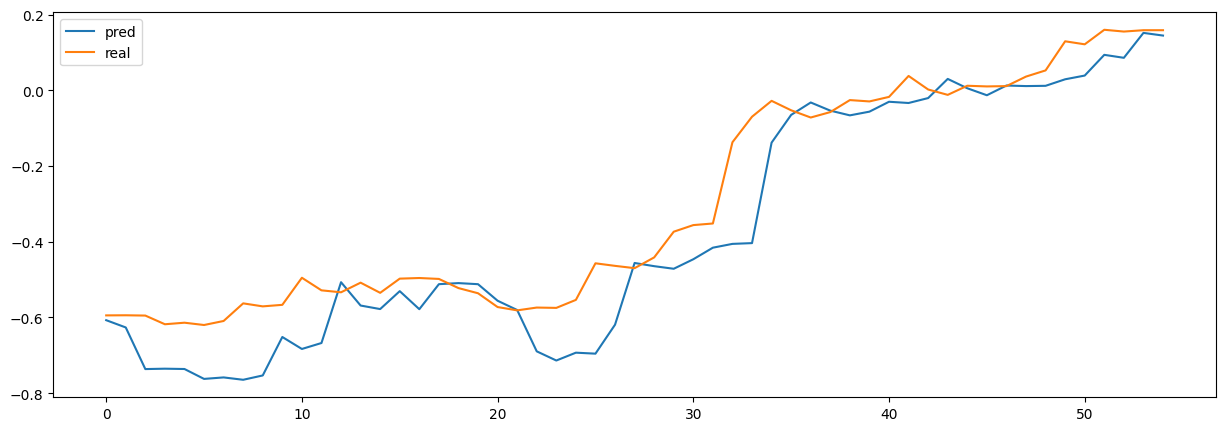

In [23]:
test_df.plot(figsize=(15,5))